In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

In [7]:
class Graph:

    def __init__(self, N):

        self.N = N
        self.construct_V_coords(N)
        self.construct_data()
        print(f"num_Vs = {self.num_Vs}")
        self.plot_graph()

    def construct_V_coords(self, N):#, fully_random=True):

        full_V_coords = np.random.uniform(-1, 2, size=(N, 2))

        # # Construct ordered vertices
        # if fully_random:
        #     full_V_coords = np.random.uniform(-1, 2, size=(N, 2))
        # else:
        #     full_V_coords = np.random.uniform(0, 1, size=(N, 2))
        #     translates = []
        #     for i in range(-1, 2):
        #         for j in range(-1, 2):
        #             translates.append(full_V_coords + np.array([i, j])) 
        #     full_V_coords = np.vstack((translates))


        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_bulk_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct bulk and boundary edges
        triangulation = scipy.spatial.Delaunay(full_V_coords)
        V, W = triangulation.vertex_neighbor_vertices
        bulk_edges = []
        boundary_edges = []
        boundary_V_inds = []
        for v_ind in range(num_bulk_Vs):
            w_inds = W[V[v_ind]:V[v_ind + 1]]
            for w_ind in w_inds:
                if v_ind < w_ind:
                    if w_ind < num_bulk_Vs:
                        bulk_edges.append([v_ind, w_ind])
                    else:
                        if not np.any(full_V_coords[w_ind] < 0):
                            boundary_edges.append([v_ind, w_ind])
                            boundary_V_inds.append(w_ind)
        bulk_edges = np.array(bulk_edges)
        boundary_edges = np.array(boundary_edges)
        boundary_V_inds = np.unique(boundary_V_inds)

        # Reindex full_V_coords to construct subset: V_coords (just bulk and boundary vertices)
        old_bulk_and_boundary_V_inds = np.concatenate((np.arange(num_bulk_Vs), boundary_V_inds))
        V_coords = full_V_coords[old_bulk_and_boundary_V_inds]

        # Fix indices in bulk and boundary edges. Create full edges
        num_boundary_Vs = boundary_V_inds.shape[0]
        new_bulk_and_boundary_V_inds = np.arange(num_bulk_Vs + num_boundary_Vs)
        old_to_new = {i: j for i, j in zip(old_bulk_and_boundary_V_inds, new_bulk_and_boundary_V_inds)}
        edges = []
        for v_ind, w_ind in np.vstack((bulk_edges, boundary_edges)):
            edges.append([old_to_new[v_ind], old_to_new[w_ind]])
        edges = np.array(edges)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.num_bulk_Vs = num_bulk_Vs
        self.V_coords = V_coords
        self.num_Vs = self.V_coords.shape[0]
        self.edges = edges
        self.triangulation = triangulation

    def construct_data(self):

        # Construct boundary map
        bulk_and_boundary_to_bulk_map = {bulk_v_num: bulk_v_num for bulk_v_num in range(self.num_bulk_Vs)}
        for boundary_v_ind in range(self.num_bulk_Vs, self.num_Vs):
            wrapped_w_coord = self.V_coords[boundary_v_ind] % 1
            distances = np.linalg.norm(self.V_coords[:self.num_bulk_Vs] - wrapped_w_coord, axis=1)
            wrapped_v_ind = distances.argmin()
            bulk_and_boundary_to_bulk_map[boundary_v_ind] = wrapped_v_ind

        LHS = scipy.sparse.lil_matrix((self.num_bulk_Vs + 1, self.num_bulk_Vs))
        RHS = np.zeros((self.num_bulk_Vs + 1, 2))
        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            wrapped_v_ind = bulk_and_boundary_to_bulk_map[v_ind]
            wrapped_w_ind = bulk_and_boundary_to_bulk_map[w_ind]
            LHS[wrapped_v_ind, wrapped_w_ind] -= 1 / l_vw
            LHS[wrapped_w_ind, wrapped_v_ind] -= 1 / l_vw
            LHS[wrapped_v_ind, wrapped_v_ind] += 1 / l_vw
            LHS[wrapped_w_ind, wrapped_w_ind] += 1 / l_vw

            r_xy = self.calculate_r_xy(v_ind, w_ind)
            RHS[wrapped_v_ind] += r_xy / l_vw
            RHS[wrapped_w_ind] -= r_xy / l_vw

        LHS[-1] = np.ones(self.num_bulk_Vs)
        LHS = scipy.sparse.csc_matrix(LHS)

        self.LHS = LHS
        self.RHS = RHS
        self.bulk_and_boundary_to_bulk_map = bulk_and_boundary_to_bulk_map

    def plot_graph(self):

        # Plot
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        ax.triplot(self.full_V_coords[:, 0], self.full_V_coords[:, 1], self.triangulation.simplices)
        ax.scatter(self.V_coords[:self.num_bulk_Vs, 0], self.V_coords[:self.num_bulk_Vs, 1], c='b', s=10)
        ax.scatter(self.V_coords[self.num_bulk_Vs:, 0], self.V_coords[self.num_bulk_Vs:, 1], c='r', s=10)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        square = matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='y', facecolor='none')
        ax.add_patch(square)
        # for en, v in enumerate(self.V_coords):
        #     ax.annotate(str(en), v, fontsize=15)

    def calculate_l_vw(self, v_ind, w_ind):
        return np.linalg.norm(self.V_coords[v_ind] - self.V_coords[w_ind])
    
    def calculate_r_xy(self, v_ind, w_ind):
        v_coords = self.V_coords[v_ind]
        w_coords = self.V_coords[w_ind]
        
        v_x_coords = self.v_coords_to_x_coords(v_coords)
        w_x_coords = self.v_coords_to_x_coords(w_coords)

        r_xy = w_x_coords - v_x_coords

        return r_xy

    def v_coords_to_x_coords(self, v_coords):
        x_coords = []
        for d in range(v_coords.shape[0]):
            if v_coords[d] < 0:
                x_coords.append(-0.5)
            elif v_coords[d] < 1:
                x_coords.append(0.5)
            else:
                x_coords.append(1.5)
        x_coords = np.array(x_coords)

        return x_coords


num_Vs = 22


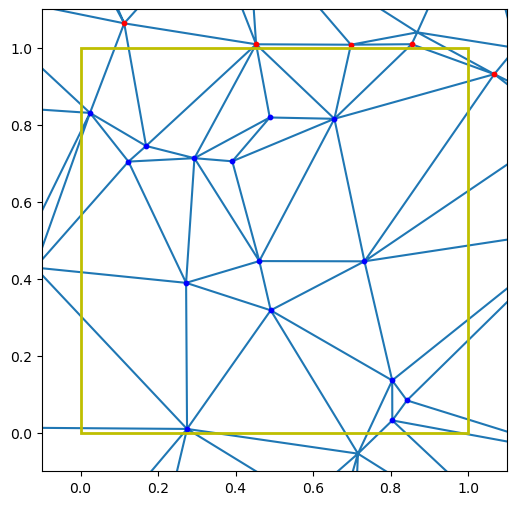

In [22]:
# np.random.seed(1)
g = Graph(100)

In [24]:
g.RHS

array([[ -4.02707743,   4.01791624],
       [  0.        , -21.41142597],
       [ -1.61556371,   5.66983717],
       [  5.06713658,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,  -8.67165928],
       [  0.        ,   5.17227336],
       [  0.        ,   0.        ],
       [  1.57122671,   0.        ],
       [  0.        ,   0.        ],
       [  1.5867173 ,   0.        ],
       [  2.33327967,  12.24639032],
       [  0.        ,   0.        ],
       [ -4.91571912,   0.        ],
       [  0.        ,   2.97666817],
       [  0.        ,   0.        ]])

In [ ]:
    def construct_data(self):

        # Construct boundary map
        bulk_and_boundary_to_bulk_map = {bulk_v_num: bulk_v_num for bulk_v_num in range(self.num_bulk_Vs)}
        for boundary_v_ind in range(self.num_bulk_Vs, self.num_Vs):
            wrapped_w_coord = self.V_coords[boundary_v_ind] % 1
            distances = np.linalg.norm(self.V_coords[:self.num_bulk_Vs] - wrapped_w_coord, axis=1)
            wrapped_v_ind = distances.argmin()
            bulk_and_boundary_to_bulk_map[boundary_v_ind] = wrapped_v_ind

        LHS = scipy.sparse.lil_matrix((self.num_bulk_Vs + 1, self.num_bulk_Vs))
        RHS = np.zeros((self.num_bulk_Vs + 1, 2))
        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            wrapped_v_ind = bulk_and_boundary_to_bulk_map[v_ind]
            wrapped_w_ind = bulk_and_boundary_to_bulk_map[w_ind]
            LHS[wrapped_v_ind, wrapped_w_ind] -= 1 / l_vw
            LHS[wrapped_w_ind, wrapped_v_ind] -= 1 / l_vw
            LHS[wrapped_v_ind, wrapped_v_ind] += 1 / l_vw
            LHS[wrapped_w_ind, wrapped_w_ind] += 1 / l_vw

            r_xy = self.calculate_r_xy(v_ind, w_ind)
            RHS[wrapped_v_ind] += r_xy / l_vw
            RHS[wrapped_w_ind] -= r_xy / l_vw

        LHS[-1] = np.ones(self.num_bulk_Vs)
        LHS = scipy.sparse.csc_matrix(LHS)

        self.LHS = LHS
        self.RHS = RHS
        self.bulk_and_boundary_to_bulk_map = bulk_and_boundary_to_bulk_map

In [12]:
alpha_x = sparseqr.solve(g.LHS, g.RHS[:, 0]) #, tolerance = 1e-9)
alpha_y = sparseqr.solve(g.LHS, g.RHS[:, 1]) #, tolerance = 1e-9)
alpha = np.vstack((alpha_x, alpha_y)).T
print(f"err = {np.linalg.norm(g.LHS @ alpha - g.RHS)}")

err = 1.6602481034747553e-10


In [21]:
Q = np.zeros((2, 2))
T = 0

for v_ind, w_ind in g.edges:
        
    l_vw = g.calculate_l_vw(v_ind, w_ind)
    r_xy = g.calculate_r_xy(v_ind, w_ind)

    a_vw = r_xy + alpha[g.bulk_and_boundary_to_bulk_map[w_ind]] - alpha[g.bulk_and_boundary_to_bulk_map[v_ind]]

    q = np.tensordot(a_vw, a_vw, axes=0) / l_vw

    Q += q
    T += l_vw

print(Q / T)
print(np.trace(Q / T))
print(np.trace(Q / T) / 0.93)

[[ 0.46020977 -0.00305872]
 [-0.00305872  0.46186457]]
0.9220743415300299
0.9914777865914299


Num Vs = 61


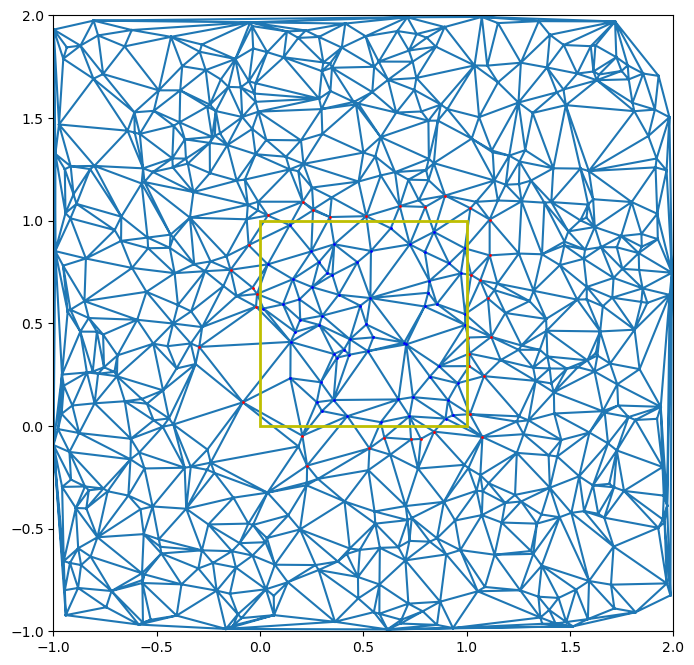

In [90]:
np.random.seed(1)
g = Graph(600)

In [95]:
translates = []
for i in range(-1, 2):
    for j in range(-1, 2):
        translates.append(g.V_coords[:g.num_bulk_Vs] + np.array([i, j])) 
extra_V_coords = np.vstack((translates))
triangulation = scipy.spatial.Delaunay(extra_V_coords)

(-0.2, 1.2)

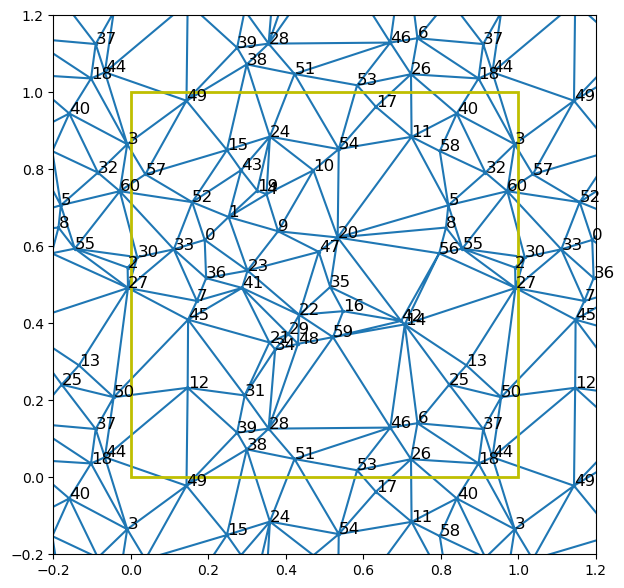

In [96]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.scatter(extra_V_coords[:, 0], extra_V_coords[:, 1], s=2)
ax.triplot(extra_V_coords[:, 0], extra_V_coords[:, 1], triangulation.simplices)

for en, v in enumerate(extra_V_coords):
    ax.annotate(str(en%g.num_bulk_Vs), v, fontsize=12)

square = matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='y', facecolor='none')
ax.add_patch(square)
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)

In [60]:
LHS = scipy.sparse.csc_matrix(np.vstack((g.periodic_wlaplacian_matrix.A, np.ones((g.num_bulk_Vs))[np.newaxis, :])))
RHS = scipy.sparse.csc_matrix(np.vstack((g.r, np.array(([0, 0])))))
RHS0 = (RHS[:, 0].A).flatten()
RHS1 = (RHS[:, 1].A).flatten()

In [61]:
alpha0 = sparseqr.solve(LHS, RHS0) #, tolerance = 1e-9)
alpha1 = sparseqr.solve(LHS, RHS1) #, tolerance = 1e-9)

In [62]:
alpha = np.vstack((alpha0, alpha1)).T
print(f"err0 = {np.linalg.norm(LHS @ alpha0 - RHS0)}")
print(f"err1 = {np.linalg.norm(LHS @ alpha1 - RHS1)}")

err0 = 1.2689681416822716
err1 = 3.5439238155661665


In [63]:
Q = np.zeros((2, 2))
T = 0

for v, w in zip(*g.full_wadjacency_matrix.nonzero()):
    if v < g.num_bulk_Vs:
        l_vw = 1 / g.full_wadjacency_matrix[v, w]
        r_xy = g.v_to_X(g.V_coords[w]) - g.v_to_X(g.V_coords[v])

        a_vw = r_xy + alpha[g.boundary_to_bulk[w]] - alpha[g.boundary_to_bulk[v]]
        
        q = np.tensordot(a_vw, a_vw, axes=0) / l_vw

        T += l_vw
        Q += q

print("Q / T = ")
print(Q / T)
print()
print("Trace = ")
print(np.trace(Q / T))
print()
print("Trace / 0.93 = ")
print(np.trace(Q / T) / 0.93)
# print()

Q / T = 
[[ 3.78058446 -0.18355265]
 [-0.18355265  3.37201036]]

Trace = 
7.1525948149433916

Trace / 0.93 = 
7.690962166605797


In [62]:
class Graph:

    def __init__(self, N):

        self.construct_V_coords(N)
        self.construct_solve_data()

    def construct_V_coords(self, N):

        full_V_coords = np.random.uniform(-1, 2, size=(N, 2))
        bulk_mask = (0 < full_V_coords) & (full_V_coords < 1)
        bulk_V_inds = bulk_mask[:, 0] & bulk_mask[:, 1]
        num_bulk_Vs = np.sum(bulk_V_inds)
        full_V_coords = np.vstack((full_V_coords[bulk_V_inds], full_V_coords[~bulk_V_inds]))

        self.num_bulk_Vs = num_bulk_Vs
        self.full_V_coords = full_V_coords

        self.triangulation = scipy.spatial.Delaunay(full_V_coords)

        # Construct edges
        V, W = self.triangulation.vertex_neighbor_vertices 
        bulk_edges = []
        boundary_edges = []
        boundary_V_inds = []

        for v_num in range(num_bulk_Vs):
            w_nums = W[V[v_num]:V[v_num + 1]]
            for w_num in w_nums:
                if v_num < w_num:
                    if w_num < num_bulk_Vs:
                        bulk_edges.append([v_num, w_num])
                    else:
                        if np.any(self.full_V_coords[w_num] < 0):
                            pass
                        else:
                            boundary_edges.append([v_num, w_num])
                            boundary_V_inds.append(w_num)

        self.bulk_edges = bulk_edges
        self.boundary_edges = boundary_edges
        self.boundary_V_inds = np.unique(boundary_V_inds)
        self.num_boundary_Vs = len(self.boundary_V_inds)
        self.num_Vs = self.num_bulk_Vs + self.num_boundary_Vs

        new_inds = np.arange(self.num_Vs)
        old_inds = np.concatenate((np.arange(self.num_bulk_Vs), self.boundary_V_inds))        
        self.boundary_V_inds = np.arange(self.num_boundary_Vs) + self.num_bulk_Vs
        self.remap = {i: j for i, j in zip(old_inds, new_inds)}
        
        self.boundary_edges = [[self.remap[v], self.remap[w]] for v, w in self.boundary_edges]
        self.edges = np.array(self.bulk_edges + self.boundary_edges)
        
        self.V_coords = np.vstack((self.full_V_coords[:self.num_bulk_Vs], self.full_V_coords[self.boundary_V_inds]))

        self.boundary_to_bulk = self.construct_boundary_to_bulk_map(self.V_coords, np.arange(self.num_bulk_Vs), self.boundary_V_inds)

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.triplot(self.full_V_coords[:, 0], self.full_V_coords[:, 1], self.triangulation.simplices)
        ax.set_xlim(-1.1, 2.1)
        ax.set_ylim(-1.1, 2.1)
        ax.scatter(self.V_coords[:self.num_bulk_Vs, 0], self.V_coords[:self.num_bulk_Vs, 1], c='b')
        ax.scatter(self.V_coords[self.num_bulk_Vs:, 0], self.V_coords[self.num_bulk_Vs:, 1], c='r')
        for en, v in enumerate(self.V_coords):
            if en < self.num_bulk_Vs:
                ax.annotate(str(en), v, fontsize=20, c='b')
            else:
                ax.annotate(str(en), v, fontsize=20, c='r')
        plt.show()

    def construct_solve_data(self):

        wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
        for v, w in self.edges:
            l_vw = np.linalg.norm(self.V_coords[v] - self.V_coords[w])
            wadjacency_matrix[v, w] = 1 / l_vw
            wadjacency_matrix[w, v] = 1 / l_vw

        wlaplacian = np.array(np.diag(np.sum(wadjacency_matrix.A, axis=0)) - wadjacency_matrix)

        r = np.zeros((self.num_bulk_Vs, 2))
        for v, w in zip(*wadjacency_matrix.nonzero()):
            if v < self.num_bulk_Vs:
                l_vw = 1 / wadjacency_matrix[v, w]
                rv = (self.v_to_X(self.V_coords[w]) - self.v_to_X(self.V_coords[v])) / l_vw
                r[v] += rv

        self.wadjacency_matrix = wadjacency_matrix
        self.wlaplacian = wlaplacian
        self.r = r

        L_ll = np.zeros((self.num_boundary_Vs, self.num_bulk_Vs))
        for en, v in enumerate(self.boundary_to_bulk):
            L_ll[en, self.boundary_to_bulk[v]] = 1
        self.L_ll = L_ll

    def construct_boundary_to_bulk_map(self, full_V_coords, bulk_V_inds, boundary_V_inds):

        boundary_to_bulk = {}
        bulk_coords = full_V_coords[bulk_V_inds]

        for v in boundary_V_inds:
            wrapped_v_coord = full_V_coords[v] % 1
            distances = np.linalg.norm(bulk_coords - wrapped_v_coord, axis=1)
            closest_bulk_index = np.argmin(distances)
            boundary_to_bulk[v] = bulk_V_inds[closest_bulk_index]

        return boundary_to_bulk
    
    def v_to_X(self, v):
        X = []
        for i in range(2):
            if v[i] < 0: X.append(-0.5)
            elif v[i] < 1: X.append(0.5)
            else: X.append(1.5)
        return np.array(X)

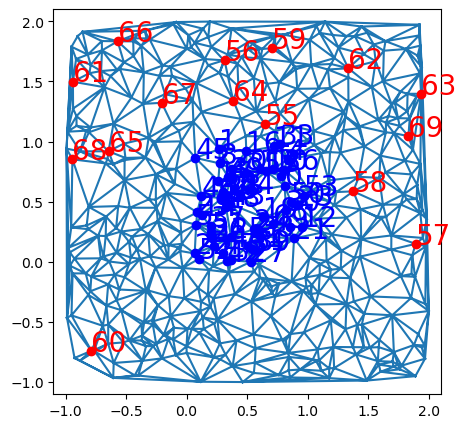

In [72]:
np.random.seed(0)
g = Graph(500)

In [73]:
LHS = g.wlaplacian[:g.num_bulk_Vs, :g.num_bulk_Vs] - g.wlaplacian[:g.num_bulk_Vs, g.num_bulk_Vs:] @ g.L_ll
RHS = g.r

In [74]:
alpha = np.linalg.solve(LHS, RHS)

In [75]:
Q = np.zeros((2, 2))
T = 0

for v, w in zip(*g.wadjacency_matrix.nonzero()):
    if v < g.num_bulk_Vs:
        if w < g.num_bulk_Vs:
        
            l_vw = 1 / g.wadjacency_matrix[v, w]
            r_xy = g.v_to_X(g.V_coords[w]) - g.v_to_X(g.V_coords[v])

            q = np.tensordot(r_xy + alpha[w] - alpha[v], r_xy + alpha[w] - alpha[v], axes=0) / l_vw
            t = l_vw

            T += t 
            Q += q

print(Q / T)
# print((Q / tr) / (0.93 / 2))
# print()

[[ 0.02592268 -0.00723773]
 [-0.00723773  0.01470329]]
